# Load and Preprocess data

In [13]:
# add bias term
def addBias(data):
    data = np.insert(data, data.shape[0], 1, axis=0)
    return data
# activation function
#1. for hidden layer
def ReLU(X,W):
    a = np.dot(W.T, X)
    return a * (a > 0)
#2. for output layer
def softMax(X, W):
    ak = np.dot(W.T, X)
    scores = np.exp(ak)
    return scores / np.sum(scores, axis=0, keepdims=True)

# randomly shuffle the data
def shuffle(X, t):
    ind = np.random.permutation(t.size)
    X, t = X[:, ind], t[ind]
    return X, t

def plot_losses(method):
    fig, ax = plt.subplots()
    niter = method.loss.shape[1]
    x = np.linspace(1, niter / method.miniBatch, niter)
    ax.plot(x, method.loss[0], label="train loss")
    if method.earlyStop:
        ax.plot(x, method.loss[1], label="validation loss")
        ax.plot(x, method.loss[2], label="test loss")
    else:
        ax.plot(x, method.loss[1], label="test loss")
    ax.legend()


def plot_errors(method):
    fig, ax = plt.subplots()
    niter = method.error.shape[1]
    x = np.linspace(1, niter / method.miniBatch, niter)
    ax.plot(x, 1 - method.error[0], label="train percent correct")
    if method.earlyStop:
        ax.plot(x, 1 - method.error[1], label="validation percent correct")
        ax.plot(x, 1 - method.error[2], label="test percent correct")
    else:
        ax.plot(x, 1 - method.error[1], label="test percent correct")
    ax.legend(loc="lower right")

In [14]:
from mnist import MNIST
import math
import numpy as np

mndata = MNIST('.')
trainData, trainLabel = mndata.load_training()
testData, testLabel = mndata.load_testing()

trainData = np.array(trainData).T / 255.
trainLabel = np.array(trainLabel).T
testData = np.array(testData).T / 255.
testLabel = np.array(testLabel).T

# zero mean and unit variance
trainData -= np.mean(trainData, axis=0)
trainData /= np.std(trainData, axis = 0)

testData -= np.mean(testData, axis=0)
testData /= np.std(testData, axis = 0)

testData = addBias(testData)

In [15]:
class multiLayer():
    def __init__(self, trainData, trainLabel, nHiddenLayer = (100,), \
               lr = 1e-3, anneal = 0., maxIter = 1000, earlyStop=3, \
               miniBatch = 1, lam = 0., momentum = 0.9, actFuns=("ReLU","softMax")):
        self.X = trainData
        self.t = trainLabel
        self.X = addBias(self.X)
        self.earlyStop = earlyStop
        self.nClass = len(np.unique(trainLabel))
        if earlyStop:
            validSize = self.X.shape[1] / 6
            self.xValid = self.X[:,:validSize]
            self.tValid = self.t[:validSize]
            self.X = self.X[:,validSize:]
            self.t = self.t[validSize:]
        self.actFuns = actFuns
        self.lam = lam
        self.miniBatch = miniBatch
        self.loss = np.array([[], [], []]) if earlyStop else np.array([[], []])
        self.error = np.array([[], [], []]) if earlyStop else np.array([[], []])
        nLayer = len(nHiddenLayer) + 1
        nUnits = (self.X.shape[0],) + nHiddenLayer + (self.nClass,)
        self.W = [1 / np.sqrt(nUnits[i]) *  \
                  np.random.randn(nUnits[i], nUnits[i + 1]) for i in xrange(nLayer)]
        self.W = self.train(self.W, lr, maxIter, anneal, earlyStop, miniBatch, momentum)
        
    def train(self, weights, lr, maxIter, anneal, earlyStop, miniBatch, mu):
        d,n = self.X.shape
        batchSize = n / miniBatch
        wRecords = [[] for _ in weights]
        v = [0 for _ in weights]
        trainLoss = trainError = validLoss = validError = testLoss = testError = 0
        it = 0
        while it < maxIter:
            startInd , endInd = 0, batchSize
            self.X, self.t = shuffle(self.X, self.t)
            for i in xrange(miniBatch):
                xBatch, tBatch = self.X[:, startInd:endInd], self.t[startInd:endInd]
                    
                if anneal:
                    if it * miniBatch + i > 5:
                        lr1 = lr / (1. + it / anneal)
                    else:
                        lr1 = 1e0
                else:
                    lr1 = lr
                    
                outputs = self.forwardProp(xBatch, weights)
                dW = self.backProp(xBatch, tBatch, outputs, weights)
                trainLoss, trainError = self.evalLossError(xBatch, tBatch, weights)
                    
                if i % 100 == 0:
                    testLoss, testError = self.evalTest(testData, testLabel, weights)
                    
                for j in xrange(len(wRecords)):
                    wRecords[j].append(np.array(weights[j]))
                    
                if earlyStop:
                    self.loss = np.hstack([self.loss, [[trainLoss], [validLoss], [testLoss]]])
                    self.error = np.hstack([self.error, [[trainError], [validError], [testError]]])
                    if i % 100 == 0:
                        validLoss, validError = self.evalLossError(self.xValid, self.tValid, weights)
                else:
                    self.loss = np.hstack([self.loss, [[trainLoss], [testLoss]]])
                    self.error = np.hstack([self.error, [[trainError], [testError]]])
                    
                for j in xrange(len(weights)):
                    vPrev = v[j]
                    v[j] = mu * v[j] - lr * dW[j]
                    weights[j] += -mu * vPrev + (1 + mu) * v[j]
                    
                startInd, endInd = startInd + batchSize, endInd + batchSize if i != miniBatch - 1 else n
                
            if earlyStop:
                print trainLoss, trainError, validLoss, validError, testLoss, testError
                if it != 0 and self.error[1, -1] >= self.error[1, -1 - miniBatch]:
                    stopCondition += 1
                    if stopCondition == earlyStop:
                        ind = self.error[2, :].argmin()
                        return [wRecord[ind] for wRecord in wRecords]
                else:
                    stopCondition = 0
            else:
                print trainloss, trainError, testLoss, testError
            it += 1
        if earlyStop:
            ind = self.error[2, :].argmin()
            weights = [wRecord[ind] for wRecord in wRecords]
        return weights
        
    def evalLossError(self, X, t, weights):
        outputs = self.forwardProp(X, weights)
        y = outputs[-1]
        n = t.size
        loss = -np.sum(np.log(y[t, range(n)])) / n
            
        for weight in weights:
            loss += (np.sum(weight * weight)) * self.lam
            
        prediction = y.argmax(axis = 0)
        error = np.mean(prediction != t)
        return loss, error
        
    def forwardProp(self, X, weights):
        outputs = [X]
        for weight, actFun in zip(weights, self.actFuns):
            if actFun == "softMax":
                outputs.append(softMax(outputs[-1], weight))
            elif actFun == "ReLU":
                outputs.append(ReLU(outputs[-1], weight))
        return outputs[1:]
        
    def backProp(self, X, t, outputs, weights):
        n = t.size
        dW = []
        outputs = [X] + outputs
        for i in xrange(len(weights) - 1, -1, -1):
            output1, output2 = outputs[i], outputs[i + 1]
            if self.actFuns[i] == "softMax":
                output2[t, range(n)] -= 1
                delta = output2 / n
                dW.append(np.dot(output1, delta.T))
            elif self.actFuns[i] == "ReLU":
                delta = (1. * (output2 > 0)) * np.dot(weights[i + 1], delta)
                dW.append(np.dot(output1, delta.T))
        dW = dW[::-1]
        
        for i in xrange(len(weights)):
            dW[i] += 2 * weights[i] * self.lam
        return dW
    
    def evalTest(self, xTest, tTest, weights = 0):
        if type(weights) is int:
            return self.evalLossError(xTest, tTest, self.W)
        else:
            return self.evalLossError(xTest, tTest, weights)
    
    def plot_losses(self):
        plot_losses(self)

    def plot_errors(self):
        plot_errors(self)

In [22]:
multilayer = multiLayer(trainData, trainLabel, lr = 1e-2, earlyStop = 3, maxIter = 20,\
                        actFuns=('ReLU', 'ReLU','softMax'), lam = 0., miniBatch = 500, nHiddenLayer = (100, 100))

0.225466019623 0.06 0.176646997553 0.0542 0.172993190469 0.0535
0.0637489000447 0.01 0.129476255578 0.0362 0.11854952044 0.0362
0.0614752701083 0.02 0.118759082972 0.0355 0.108187035332 0.0352
0.0949576319913 0.04 0.0993597043908 0.0308 0.0895987734321 0.0265
0.0458456253275 0.02 0.0972165193743 0.029 0.0869981151173 0.0267
0.0406889022895 0.01 0.102654727826 0.0308 0.094722109232 0.0293
0.0250780661807 0.01 0.0934824330532 0.0265 0.0804262440621 0.0241
0.0259106333755 0.01 0.0873306823859 0.0257 0.0826177381548 0.0254
0.00863410813586 0.0 0.0864256646148 0.0247 0.0799381257624 0.0221
0.0207848824288 0.01 0.089362238532 0.0242 0.0795631076755 0.0229
0.014053580171 0.01 0.0934700433442 0.0244 0.0867467392697 0.0236
0.0209965220507 0.01 0.0887341315901 0.0237 0.078090483532 0.0217
0.00632034368463 0.0 0.0917948183999 0.0234 0.0842689337766 0.0217
0.00321801131862 0.0 0.0898143125688 0.0231 0.0827935378345 0.022
0.0118356547229 0.0 0.0916958303009 0.0223 0.0839676661956 0.0208
0.002017768

0.98


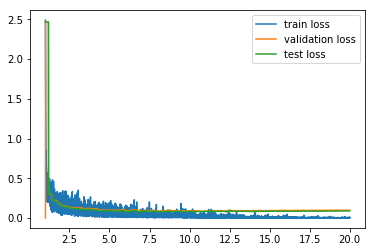

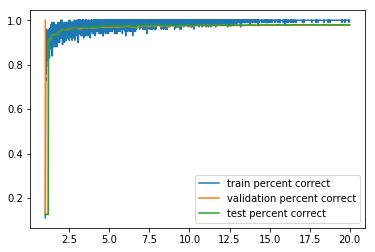

In [23]:
import matplotlib.pyplot as plt
test_loss, test_error = multilayer.evalTest(testData, testLabel)
print 1 - test_error
multilayer.plot_losses()
multilayer.plot_errors()
plt.show()